# Lecture 4
We will now look at ways to run a computational process and monitor it as it performs the assigned task. At some moment our algorithm will decide that solution progressed enough to make some decision and will restart it with parameters changed according to what we programmed. The task itself, the communication and the process will vary greatly from case to case, but in general we will need to:
* Start an external application with proper command line arguments.
    * This can be done either in a blocking (the thread serving our Python console will not be accessible, and will lock for the execution of the called program)
    * Or in a nonblocking way, by spawning a separate process to deal with the problem, while our Python console will return control for us to perform various tasks.
* Read data from a file to which the program stores the interesting value.
* Modify settings of the program, either via command line arguments or a setting file.
* Make decisions on what to do next.

**Note**: I use more less this approach to (attempt) track the edge that possibly exists between the laminar and turbulent solution, by iteratively changing perturbation applied to the flow end examining its evolution in time, on the way deciding if the flow is going turbulent or not. The process is very much like trying to push the ball to land on the top of a hill, push it to hard and it passes to the other side, be to gentle and it will not reach the top. But in an infinite number of dimensions (before discretization).

## The model program
For a given task you will need to use a specific program. For me this is a flow solver, for you it might be ANSYS or ADAMS or something completely different. For the purpose of this presentation we will use a simple C++ program, attached to this repository. (This might not be working with MyBinder though). This program:
* stores a random value from a selected range to a file - our data.
* accepts some simple command line arguments.
* Reads a simplistic setting file.
* The source is in the tick-tick folder.

Start by building the `tick-tick` program.

## Use `os.system` call
We start by simply calling the system command, in our case it is our program. To do this we need to import `os` module:

In [ ]:
import os

In [ ]:
ls

In [ ]:
os.system('ls')

Our test program will be a simple program. The source is given here for the sake of completeness:

In [ ]:
cat ./tick-tick/main.cpp

We start with the simple call to `os.system`. OS is a module that lets our Python script interact with the operating system, and the `system()` method executes the command (a string) in a subshell. It is a blocking call, meaning for the time of execution the console is unusable.

In [ ]:
os.system('./tick-tick/build/tick-tick')
# os.system('./tick-tick/build_debug/tick-tick --period 10')

In [ ]:
ls

In [ ]:
os.system('./tick-tick/build/tick-tick --period 10')

This executes `tick-tick` program, the working directory (place where work is performed is) is the same as our current working directory. As a result `data.dat` should appear. The file content is:

In [ ]:
cat data.dat

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
t, v = np.loadtxt('data.dat', comments="#", skiprows=3, usecols=(0,1), unpack=True, delimiter=',')

In [ ]:
plt.plot(t, v)
plt.grid()

Before proceeding lets add setting file we can manipulate:

In [ ]:
f = open('./settings', 'w')
f.writelines('DT   = 0.5\n')
f.write('XMAX = 5.0\n')
f.write('XMIN = -5.0\n')
f.write('N    = 1000\n')
f.close()

In [ ]:
ls

In [ ]:
cat settings

Now we have a settings file to be passed to our process.

In [ ]:
os.system('./tick-tick/build/tick-tick --period 10 --sett settings')

In [ ]:
t, v = np.loadtxt('data.dat', comments="#", skiprows=2, usecols=(0,1), unpack=True, delimiter=',')
plt.scatter(t, v)
plt.grid()

## `subprocess`
### Blocking call:
Ultimately we would like to run the program and regain control, while the program runs. To this end we will use the `subprocess` module and a couple of `os` tools. The `subprocess` module allows to create new processes, obtain their returns and outputs. We will show only some of the functionality. Let's start with getting the output with `check_output`, that we can later parse and use:

In [ ]:
import subprocess

In [ ]:
ls -l

In [ ]:
s = subprocess.check_output(["ls", "-l"])

In [ ]:
print(s)

In [ ]:
for ss in s.splitlines():
    print(ss)

For us, more useful is `call()`. It runs command passed as argument and waits (locks control) until command completes. 

In [ ]:
com = "tick-tick/build/tick-tick"
subprocess.call(com)

If additional parameters need to be passed:

In [ ]:
com = "tick-tick/build/tick-tick --period 50 --sett settings"
subprocess.call(com, shell=True)

Note the additional `shell=True` argument. This specifies that the command will be executed through the system shell (eg. Bash) and is useful if we need to pass arguments. We can illustrate the result:

In [ ]:
t, v = np.loadtxt('data.dat', comments="#", skiprows=2, usecols=(0,1), unpack=True, delimiter=',')
plt.scatter(t, v)
plt.grid()

Example: Using the `tick-tick` program and the `call` function write a script that runs the `tick-tick` changing the number of iterations N and plots average and variance as functions of N.

1. Write a function that modifies the setting file accordingly.
2. Write a function that reads the result file and stores the results.
3. Run the process in a loop, choose some stopping criteria.

In [ ]:
def settfile(fname, N):
    '''
    Modifies the setting file
    param: fname - file to modify
    param: N - nuber of iteration do perform
    '''
    f = open(fname, 'w')
    f.writelines('DT   = 0.5\n')
    f.write('XMAX = 5.0\n')
    f.write('XMIN = -5.0\n')
    st =    'N    = ' + str(N) + '\n'
    f.write(st)
    f.close()

In [ ]:
def calculate(fname):
    '''
    Using fname calculates average and variance
    '''
    t, v = np.loadtxt(fname, comments="#", skiprows=3, usecols=(0,1), unpack=True, delimiter=',')
    s = v.sum()
    avg = s / len(t)
    s = 0
    for val in v:
        s += (val - avg)**2
    var = s / len(t)
    return avg, var

In [ ]:
'''
Run the process here
'''
n = []
av = []
va = []
for N in range(5,10000,50):
    st = 'settings'
    settfile(st, N)
#     print('Running for N=', N)
    subprocess.call("tick-tick/build/tick-tick --period 0 --sett settings", shell=True)
    a, v = calculate('data.dat')
    n.append(N)
    av.append(a)
    va.append(v)
    if N > 100 and np.abs(a) < 1.0e-3: # stopping cryteria
        break
#     print(a, v)

In [ ]:
plt.plot(n, av)
plt.grid()

In [ ]:
plt.plot(n, va)
plt.grid()

### Run and regain control with `popen()`
We will now look at a slight modification. Our goal is to be able to monitor (programmatically) the process we call and if necessary make decision, change parameters and eventually stop execution or restart. To do this we need to add a couple of things to our tool set. Fist is the `subprocess.Popen()`, which works very much like `call()`, with a difference that it executes the child (**without mercy!**) in a new process! What that means is that new, separate from our Python interpreter, process is started to handle the program, and control is returned to the interpreter to perform whatever task we wish it to do. When called `Popen` object is returned. We will outline some of functionality it provides (also see the documentation).

**The most important feature is that `Popen()` allows a nonblocking call!** meaning we can continue interacting with our script

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import subprocess
import time
from IPython.display import clear_output
import os

Note: It is good to show the process tree at this moment.

In [38]:
cmd = 'tick-tick/build/tick-tick'
p=subprocess.Popen(cmd)

None


In [39]:
for i in range(0,10):
    clear_output(wait=True)
    print(i, end='\n')
    os.system('tail data.dat')
    time.sleep(1)
# p.wait()

9
# Settings: 1000 0.1 1 -1 10
0,	 -0.736924
0.1,	 -0.0826997
0.2,	 -0.562082
0.3,	 0.357729
0.4,	 0.869386
0.5,	 0.0388327
0.6,	 -0.930856
0.7,	 0.0594004
0.8,	 -0.984604
===== Starting process =====
Period:1000
Dt:	0.1
Xmax:	1
Xmin:	-1
N:	10


0

`p` is going to be a `Popen` with which we (or our smart algorithm) can interact. There is a number of things we could do. The most important is to check if the child process is alive (`Popen.poll()`), wait for it to finish with (`Popen.wait(timeout)`), or send it a signal for termination or kill (`Popen.terminate() .kill()`). There is also an option to interact with the process passing data to `stdin` and to read from `stdout` with `Popen.communicate()`, but our program does not support this (you can try it out).

Examine:
* `p.poll()`
* `p.wait()`
* `p.pid`
* `p.terminate()` and `p.kill()`

Note: `terminate` will send `SIGTERM`, while `kill` will result in `SIGKILL` on Linux.

Note: Why `wait()` the process?
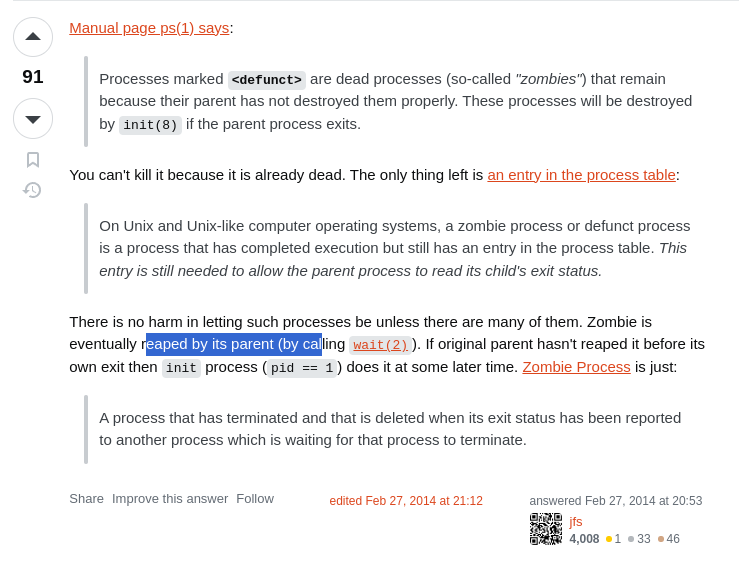

Let us see:

In [40]:
cmd = 'tick-tick/build/tick-tick'
p=subprocess.Popen(cmd)

In [41]:
pid = p.pid
poll = p.poll()
print(poll)

if poll == None:
    print('Tick-tick is still running, pid=', pid)
else:
    print('Tick-tick has finished with code:', poll, 'and return code=', p.returncode)

None
Tick-tick is still running, pid= 236656


In [42]:
p.wait()

pid = p.pid
poll = p.poll()
print(poll)

if poll == None:
    print('Tick-tick is still running, pid=', pid)
else:
    print('Tick-tick has finished with code:', poll, 'and return code=', p.returncode)

===== Starting process =====
Period:1000
Dt:	0.1
Xmax:	1
Xmin:	-1
N:	10
0
Tick-tick has finished with code: 0 and return code= 0


`wait()` without any arguments will lock and wait for the process to finish. Passing a `timeout` argument will result in `wait()` raising an error if the process does not finish. We can capture and deal with this using the `try` and `except` construct. (similar to `try` and `catch`).

In [56]:
cmd = 'tick-tick/build/tick-tick'
p=subprocess.Popen(cmd)

In [52]:
p.wait(timeout=1)

TimeoutExpired: Command 'tick-tick/build/tick-tick' timed out after 1 seconds

In [57]:
try:
    print(p.wait(timeout=2))
except:
    print('some error!')

some error!


In [58]:
pid = p.pid
poll = p.poll()
print(poll)

None


In [59]:
if poll == None:
    print('Tick-tick is still running, pid=', pid)
else:
    print('Tick-tick has finished with code:', poll, 'and return code=', p.returncode)

p.wait()
    
if poll == None:
    print('Tick-tick is still running, pid=', pid)
else:
    print('Tick-tick has finished with code:', poll, 'and return code=', p.returncode)

Tick-tick is still running, pid= 238437
===== Starting process =====
Period:1000
Dt:	0.1
Xmax:	1
Xmin:	-1
N:	10
Tick-tick is still running, pid= 238437


### Killing the p
There is nothing more pleasurable than to destroy something ...

In [64]:
cmd = 'tick-tick/build/tick-tick'
p=subprocess.Popen(cmd)

In [65]:
pid = p.pid
poll = p.poll()
print(poll)
if poll == None:
    print('Tick-tick is still running, pid=', pid)
else:
    print('Tick-tick has finished with code:', poll, 'and return code=', p.returncode)

None
Tick-tick is still running, pid= 239069


In [66]:
# p.kill()
p.terminate()

In [67]:
p.wait()

-15

In [69]:
os.system('tail data.dat')

# Recording precious random data
# t, value
# Settings: 1000 0.1 1 -1 10
0,	 -0.736924


0

In [70]:
pid = p.pid
poll = p.poll()
print(poll)
if poll == None:
    print('Tick-tick is still running, pid=', pid)
else:
    print('Tick-tick has finished with code:', poll, 'and return code=', p.returncode)

-15
Tick-tick has finished with code: -15 and return code= -15


How about the `shell=True` option, that we need when passing command line settings?

**Note**: Note additional process spawned to handle our call!

In [71]:
cmd = "tick-tick/build/tick-tick --period 1000 --sett settings"
p=subprocess.Popen(cmd, shell=True)
# p=subprocess.Popen(cmd)

In [72]:
pid = p.pid
poll = p.poll()
print(poll)
if poll == None:
    print('Tick-tick is still running, pid=', pid)
else:
    print('Tick-tick has finished with code:', poll, 'and return code=', p.returncode)

None
Tick-tick is still running, pid= 240029


In [79]:
p.kill()

In [83]:
os.system('tail data.dat')

21.5,	 2.25412
22,	 3.88572
22.5,	 -1.93678
23,	 0.132737
23.5,	 3.45982
24,	 3.41511
24.5,	 -0.846054
25,	 -0.320826
25.5,	 -3.21672
26,	 0.716548


0

In [81]:
pid = p.pid
poll = p.poll()
print(poll)
if poll == None:
    print('Tick-tick is still running, pid=', pid)
else:
    print('Tick-tick has finished with code:', poll, 'and return code=', p.returncode)

-9
Tick-tick has finished with code: -9 and return code= -9


Process is not dead!! This is because `kill()` killed the shell process, we invoked to process our call with additional options, and not the actual command, which is now a process without a parent, but a still running one. An easy fix is to add `exec` before the actual command we wish to run:

**Note**: *`exec` command in Linux is used to execute a command from the bash itself. This command does not create a new process it just replaces the bash with the command to be executed. If the exec command is successful, it does not return to the calling process.*

In [84]:
cmd = "exec tick-tick/build/tick-tick --period 1000 --sett settings"
p=subprocess.Popen(cmd, shell=True)

In [85]:
pid = p.pid
poll = p.poll()
print(poll)
if poll == None:
    print('Tick-tick is still running, pid=', pid)
else:
    print('Tick-tick has finished with code:', poll, 'and return code=', p.returncode)

None
Tick-tick is still running, pid= 241173


In [88]:
p.kill()

In [91]:
os.system('tail data.dat')

0,	 -3.68462
0.5,	 -0.413499
1,	 -2.81041
1.5,	 1.78865
2,	 4.34693
2.5,	 0.194164
3,	 -4.65428
3.5,	 0.297002
4,	 -4.92302
4.5,	 -4.33158


0

In [92]:
p.wait()

-9

In [93]:
pid = p.pid
poll = p.poll()
print(poll)
if poll == None:
    print('Tick-tick is still running, pid=', pid)
else:
    print('Tick-tick has finished with code:', poll, 'and return code=', p.returncode)

-9
Tick-tick has finished with code: -9 and return code= -9


In [ ]:
t, v = np.loadtxt('data.dat', comments="#", skiprows=2, usecols=(0,1), unpack=True, delimiter=',')
plt.scatter(t, v)
plt.grid()

### Example
Run the `tick-tick` program checking the average value and stopping the execution when the value reaches a certain, satisfactory value and stays there for some time.

In [ ]:
import time

In [ ]:
def calculate(fname):
    '''
    Using fname calculates average and variance
    '''
    t, v = np.loadtxt(fname, comments="#", skiprows=3, usecols=(0,1), unpack=True, delimiter=',')
    s = v.sum()
    avg = s / len(t)
    s = 0
    for val in v:
        s += (val - avg)**2
    var = s / len(t)
    return avg, var

In [ ]:
'''
Run the process here
'''
p=subprocess.Popen('exec tick-tick/build/tick-tick --period 10 --sett settings', shell=True)

In [ ]:
nn = []
av = []
while True:
    if p.poll() != None:
        print(p.pid, 'Is not working')
        break
    time.sleep(1)
    
    a, v = calculate('data.dat')
    nn.append(len(av))
    av.append(a)
    print(len(av), a)
    if np.abs(a) < 1e-5:
        p.terminate()
        print(p.pid, 'is now dead')

plt.plot(nn, av)
plt.grid()